<a id='top'></a>
# <u>*Program–Rating Classifier*</u>
#### The following code demonstrates the development and refinement of a binary text classifier designed to read and ingest data from two sub-reddit threads of popular television programs. I will be using the Pushshift api to navigate throughout Reddit.com and the two forementioned sub-reddits. The penultimate is to establish a classifier that will group posts by identifying key terms associated with each topic and then looking for them in the text. Our final step is to have a classifier that is ready to be tested and strengthened through user feedback.

* [Subreddit Scraping](#scraping)
* [Data Clean](#cleaning)
* [Initial Classifier](#logreg)
* [Advanced Modeling Techniques](#moremodels)
----
----
----

In [24]:
# Importing Webscraping, data managment and visualization libraries

import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

import requests
from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,\
AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,\
ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#
import xgboost as xgb

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christophervolpacchio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christophervolpacchio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id ='scraping'></a> 

In [25]:
"""
LOOP SCRAPER THROUGH SUBREDDITS WITH SEEDED DATAFRAME.
""";
# We are quickly reading in old scrapes to continue to feed our model.
    # As we continue to scrape the training data will continue to grow.
def reddit_scrape(subreddit):
    api_url='https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit' : subreddit,
    'size' : 1}
    res = requests.get(api_url, params)
    data = res.json()
    posts = data['data']
    df = pd.DataFrame(posts)
    count=0
    while count < 21:
        api_url='https://api.pushshift.io/reddit/search/submission'
        params = {
            'subreddit' : subreddit,
            'size' : 100, # Current PushShift API limit.
            'before' : min(df['created_utc'])}
        res = requests.get(api_url, params)
        print(res.status_code)
        data = res.json()
        # res.content shows key as 'data'.
        posts = data['data']
        df1 = pd.DataFrame(posts)
        df = df.append(df1)
        count += 1
    return df

In [26]:
n1 = '\n'
arthur_df = reddit_scrape('Arthur')
arthur_df.to_csv('./arthur.csv')
attack_df = reddit_scrape('titanfolk')
attack_df.to_csv('./titanfolk.csv')
print(f"DF1 : {len(arthur_df)} records{n1}DF2 : {len(attack_df)} records")

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
DF1 : 914 records
DF2 : 2101 records


In [27]:
# We will slice our 'attack_df' to the approximate size of our Arthur data.

attack_df = attack_df[:920]
n1='\n'
print(f"{arthur_df[['subreddit','title','selftext']].info()}{attack_df[['subreddit','title','selftext']].info()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  914 non-null    object
 1   title      914 non-null    object
 2   selftext   912 non-null    object
dtypes: object(3)
memory usage: 28.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 18
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  920 non-null    object
 1   title      920 non-null    object
 2   selftext   916 non-null    object
dtypes: object(3)
memory usage: 28.8+ KB
NoneNone


<a id ='cleaning'></a> 

In [28]:
attack_df = attack_df[['subreddit','title','selftext']]
attack_df1 = attack_df.copy()
attack_df1.dropna(inplace = True)
attack_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916 entries, 0 to 18
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  916 non-null    object
 1   title      916 non-null    object
 2   selftext   916 non-null    object
dtypes: object(3)
memory usage: 28.6+ KB


In [29]:
arthur_df = arthur_df[['subreddit','title','selftext']]
arthur_df1 = arthur_df.copy()
arthur_df1.dropna(inplace = True)
arthur_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  912 non-null    object
 1   title      912 non-null    object
 2   selftext   912 non-null    object
dtypes: object(3)
memory usage: 28.5+ KB


---
### Importing pre-defined 'Stop Word' lists and using their union as a *super-set*. We will also be extracting program-specific text such as character names and locations to make classifier more reproducable.

#### We are trying to gauge the general sentiment and tenor of each post to determine whether they would be TV–MA (Attack On Titan!) or TV–Y (Arthur) rated content.
---

<a id ='stops'></a> 

In [30]:
stops0 = list(stopwords.words('english'));
# This will return a tuple of index keys and strings that we will turn into a DataFrame.
stops1 = pd.DataFrame(CountVectorizer(stop_words = 'english').get_stop_words());
stops1['words']= stops1[0];
stops1 = list(stops1['words'].items());

# We are forced to use an extra step to extract information here because we are dealing with a from a 'Frozen Dictionary'.

stop_words = []
for i in stops1:
    stop_words.append(i[1]);

# Finalizing the creation of a more comprehensive list of stop words

stop_words = stop_words + stops0;
df = pd.DataFrame(stop_words);
stop_words = list(df[0].unique());
print(f"String Count : {len(df[0])}, Unique Count : {len(df[0].unique())}")

String Count : 497, Unique Count : 378


In [31]:
# Here we will begin to look into program-specific stop words.

arthur_df = arthur_df1
cvec = CountVectorizer(lowercase = True, strip_accents = 'ascii', stop_words = list(stop_words))

X = arthur_df['selftext']
y = arthur_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

X_train = cvec.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
top_words = {}

# Loop through dataframe columns.
for i in X_train_df.columns:
    # Saving 'sum' of each column in dictionary.
    top_words[i] =  X_train_df[i].sum()
    
# Casting top_words to a dataframe sorted by descending frequency.
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

most_freq[:20]

############################
############################
############################



#"""
#Can be good TO LOOK AT A DIST OF TERMS TO SEE WHERE IT IS WORTH CUTTING OFF
#"""
#top_words[i] = X_train_df[i].sum() 

#plt.bar(most_freq[0][:10], most_freq[1][:10]);

,0,1
0,arthur,235
1,episode,166
2,like,111
3,know,81
4,https,65
5,think,59
6,episodes,58
7,remember,53
8,com,45
9,kids,45


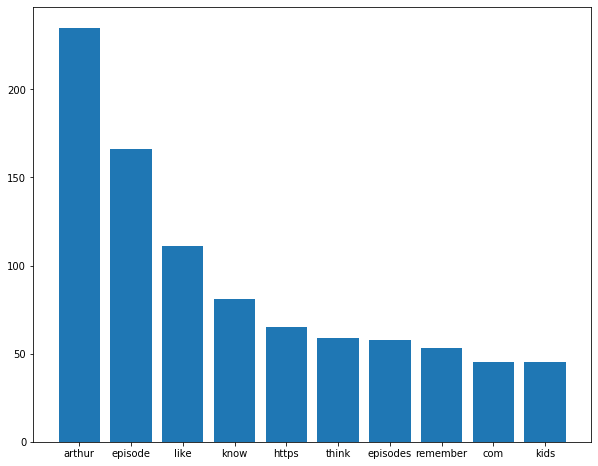

In [32]:
top_words[i] = X_train_df[i].sum() 

plt.figure(figsize = (10,8))
plt.bar(most_freq[0][:10], most_freq[1][:10]);

In [33]:
arthur_df_stops = ['arthur','buster','muffy','francine', 'binky','dw']
for i in arthur_df_stops:
    stop_words.append(i);
stop_words = set(stop_words)
stop_words = list(stop_words)
print(f'{len(stop_words)} Stop Words')

384 Stop Words


In [34]:
attack_df = attack_df1[1:]
cvec = CountVectorizer(lowercase = True, strip_accents = 'ascii', stop_words = list(stop_words))

X = attack_df['selftext']
y = attack_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

X_train = cvec.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
top_words = {}

# Loop through dataframe columns.
for i in X_train_df.columns:
    # Saving 'sum' of each column in dictionary.
    top_words[i] =  X_train_df[i].sum()
    
# Casting top_words to a dataframe sorted by descending frequency.
most_freq = pd.DataFrame(sorted(top_words.items(), key = lambda x: x[1], reverse = True))

most_freq[:20]

,0,1
0,eren,432
1,amp,208
2,historia,148
3,like,130
4,https,113
5,titan,107
6,png,96
7,deleted,86
8,think,82
9,poll,77


In [35]:
attack_stops = ['https','historia','armin','titans','mikasa','eren']
for i in attack_stops:
    stop_words.append(i);
stop_words = set(stop_words)
stop_words = list(stop_words)
print(f'{len(stop_words)} Stop Words')

390 Stop Words


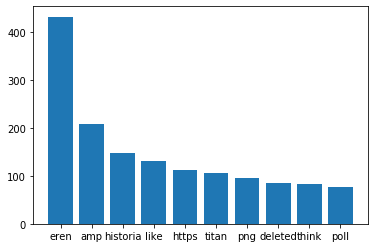

In [36]:
top_words[i] = X_train_df[i].sum() 

plt.bar(most_freq[0][:10], most_freq[1][:10]);

---
### Here we will run through our first model stripped-down model devoid of any hyperparameters, gridsearching, pipelining, etc.
#### We will also establish the baseline accurracy rate that we are to measure against.
---

<a id ='logreg'></a> 

In [37]:
df = arthur_df[['subreddit', 'title', 'selftext']].append(attack_df[['subreddit', 'title', 'selftext']])
len(df)

1827

In [38]:
df['subreddit'] = df['subreddit'].map({'Arthur' : 0, 'titanfolk' : 1})
df.head()

,subreddit,title,selftext
0,0,I have a parody Arthur account on Twitter and ...,
0,0,Arthur MBTI?,What MBTI-type do you think all the characters...
1,0,Food question,[deleted]
2,0,What episode did this happen on?,The one where Arthur roasts DW to a crisp aski...
3,0,Muffy and DW,[deleted]


In [39]:
# There should NOT be any NA values at this point, however, we will run another clean to be safe.
df.dropna(axis = 0, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 18
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1827 non-null   int64 
 1   title      1827 non-null   object
 2   selftext   1827 non-null   object
dtypes: int64(1), object(2)
memory usage: 57.1+ KB


In [40]:
df['subreddit'].value_counts(normalize = True)

1    0.500821
0    0.499179
Name: subreddit, dtype: float64

In [41]:
# Our model must predict PG-rated content with > % accurracy of predicting a '1' in order to beat the baseline.

In [42]:
# Here we will 'tokenize' the words in each subreddit post and split our data to train our initial model.

cvec = CountVectorizer(lowercase = True, strip_accents = 'ascii', stop_words = list(stop_words))

X = df['selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 42)

In [43]:
# Training a Logistic Regression classifier and measuring it's predictive accurracy.

X_train = cvec.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_test = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test.toarray(),
                          columns=cvec.get_feature_names())

In [44]:
# Instantiation, fitting and assessment of our model.
lr = LogisticRegression()
lr.fit(X_train_df, y_train)
n1 = '\n'
print(f"Our model will predict a PG-rated program thread with {round((lr.score(X_train_df, y_train))*100,1)}% accurracy.{n1}Untrained data will predict with {round((lr.score(X_test_df, y_test))*100,1)}% accurracy.")

Our model will predict a PG-rated program thread with 74.7% accurracy.
Untrained data will predict with 68.8% accurracy.


---
---
## We have <u>successfully</u> trained a model to have more predictive power than what we would infer from a breakdown of thread data alone.

### We must now understand the *types* of errors that our model is returning as well as attempt to improve our predictive power through other models.
---
---

---

#### I will first go up and *double* the record count to see if that will strengthen the model (whichever one that ends up being, anyway).

---

<a id ='moremodels'></a> 

### More Modeling

#### Since we did *<u>not</u>* achieve 100% accuracy with out initial classification model attempt it is worth additional modeling. WE will use a combination of bagging, pipelining and gridsearching to touch upon many models with many parameter combinations as well as boosting.

In [45]:
# Random forest with gridsearch hyperparams and pipelining

In [46]:
# Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that 
#selects, at each split in the learning process, a random subset of the features. 
#This process is sometimes called the random subspace method. 
"""
THIS WILL HOPEFULLY REDUCE THE HIGH VARIANCE USUALLY PRESENT TREE MODELS.
"""
rf = RandomForestClassifier() # This will ensure a new model each time.

params = {'max_depth' : [5, 10, 15],#list(range(1,100,10)),
         'max_features' : [None, 'auto'],
          'random_state' : list(range(1,100,10))}
#         'ccp_alpha' : list(range(0,5))}


# We will gridsearch hyperparameters here to determine which parameter combination will yield us the most accurate model
gs = GridSearchCV(rf, param_grid = params)

# Our data is already split so we can simply plug in what we have already cleansed for assessment.
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.6993074606891937


{'max_depth': 5, 'max_features': 'auto', 'random_state': 41}

In [47]:
gs.score(X_train, y_train)

0.7173202614379085

0.9635761589403974

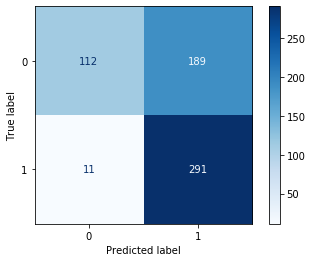

In [48]:
# Get predictions form our model and test against our actuals.
preds = gs.predict(X_test)
tn,fp,fn,tp = confusion_matrix(y_test,preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

# Calculate the specificity (TN rate) i.e. how often our model is detecting TV–MA content.
tp/(tp+fn)

---

## While our model does not display the most impressive overall accurracy, it still may prove to be very effective. 

#### Type 2 errors are the main source of our concern when we are trying to identify TV–MA content. A Type 2 error is also known as a  'false–negative' which in this case would mean that we predicted a the program content was *not* TV–MA rated though in actuality it was. Realizing this error type would be especially bad in this scenario because it would mean that we had flagged explicit content as safe for children of ages 5 and below to be watching. We would *much* rather prevent children from seeing program content that is not TV–MA (but we classify as such) than accidently showing them the oppossite. Thankfully through refinement of our model we can see that ~ 97% of TV–MA content is being properly identified. This number is referred to as our <u>True Positive Rate</u> and shows us the rate at which our model is finding unwanted content. Conversely, this would mean that ~ 3% of the time we are allowing some TV–MA content to pass through to a child viewer.

#### This measurement displays the TV content can be especially jarring for children who are accustom to a certain brand of television and are highly attentive and impressionable when watching. We must keep in mind that television whether streamed through a cable box or through internet is still a popular medium for entertainment. Condisering that the first 5 years of a child's life contribute to ~ 90% of their brain development we want to limit harmful intake as much as possible

---
----

#### In a last effort attempt to maximize our model's overall accurracy we will implement more modeling. In particular, an advanced boosting method known as XGBoost as well as pipelining will increase the number of models that our data will pass through and hopefully decrease our model variance.

----

In [49]:
# We will ultimately use a bagging (bootstrapping & aggregating) method here to deploy\
#as many additional classifiers as we see fit (no pun intended here).

In [50]:
"""
Just add in XGB and done!
"""


knn_pipe = Pipeline([('ss', StandardScaler(with_mean = False)),
                    ('knn', KNeighborsClassifier())])

vote = VotingClassifier([('ada', AdaBoostClassifier()),
                        ('grad_boost', GradientBoostingClassifier()),
                         ('XGB', xgb.XGBClassifier()),
                        ('knn_pipe', knn_pipe)])

# MUST USE DUNDERS TO DENOTE MODELS B/C OF SHARED PARAMS
params = {
    'ada__n_estimators': [100, 150, 200],
    'knn_pipe__knn__n_neighbors' : [1,2,3,4,5,10,20],
    'XGB__max_depth' : [10, 20, 30, 40],
    'XGB__booster' : ['gbtree', 'gblinear', 'dart']
}
# with KNN there are two levels to go through i.e 2 dunders
gs = GridSearchCV(vote, params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

[11:26:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:26:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:26:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:27:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:27:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:27:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:28:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:28:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:28:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:29:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:29:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:29:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:31:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:32:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:32:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:32:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:33:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:33:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:33:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:34:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:34:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:34:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:35:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:35:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:35:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:36:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:36:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:36:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:37:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:37:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:37:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:38:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:38:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:38:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:39:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:39:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:39:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:40:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:40:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:40:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:41:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:41:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:41:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:42:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:42:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:42:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:43:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:43:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:43:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:44:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:44:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:45:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

[11:46:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:46:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:46:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip 

{'XGB__booster': 'gblinear',
 'XGB__max_depth': 40,
 'ada__n_estimators': 150,
 'knn_pipe__knn__n_neighbors': 4}